<div style="color:#ed145b;font-family:inter;font-size:36px; text-align:center"><b>Treinamento modelo Word2Vec</b></div>

<div style="color:#ed145b;font-family:inter;font-size:32px">Bibliotecas e dados</div>
<hr style="background-color:#ed145b;height:4px"></hr>

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
np.random.seed(2048)

import warnings
warnings.filterwarnings("ignore")

# NLP
import spacy
import unidecode

# Modelo Word2Vec utilizado
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Modelo de sentimento genérico para comparação
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# Sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot dos resultados
import matplotlib.pyplot as plt

# Salvar modelo
import pickle

In [2]:
# Tratamento das colunas dos áudios transcritos
dados_treino = pd.read_csv("Analise_audios_transcritos.csv")

map_colunas = ["Flg_lido", "Id", "Texto_AI", "Mediu_NPS", "Sentimento", "Nivel_sentimento",
              "Area_critica", "Transcricao_manual"]

dados_treino.columns = map_colunas

# Remover áudios com erro
dados_treino = dados_treino[dados_treino["Flg_lido"] == "Sim"]

<div style="color:#ed145b;font-family:inter;font-size:32px">Treinamento Word2Vec</div>
<hr style="background-color:#ed145b;height:4px"></hr>

<ul style="color:black;font-family:inter;font-size:13px">Para o treinamento, será utilizado o <b>modelo de Word2Vec</b> ao invés do modelo tradicional de Onehot encoder, pois:
    <li>O modelo de Onehot Encoder cria um vetor de zeros inicial para com tamanho de todo o vocabulário distinto e preenche em 1 quando a frase possui a palavra. Deste modo, com o aumento de áudios, o vetor cresce, e o modelo fica menos eficiente ou demanda mais tempo para treinar</li>
    <li>O modelo de Word2Vec, tanto o CBOW quanto Skipgrams, cria um vetor de tamanho fixo único de pesos para cada palavra, considerando seu contexto na frase, isso torna o modelo mais eficiente e inteligente.</li>
</ul>

In [68]:
def trata_textos(doc):
    tokens_validos = list()
    
    for token in doc:
        token_e_valido = not token.is_stop and token.is_alpha
        # O Token deve ser alfabético e não ser uma Stop Word
        if token_e_valido:
            tokens_validos.append(token.text)

    if len(tokens_validos) > 2:
        return " ".join(tokens_validos)

In [4]:
nlp = spacy.load("pt_core_news_sm")

In [5]:
# Tratamento dos textos: retirada de stopwords e caracteres não alfanuméricos
textos_para_tratamentos = (titulos.lower() for titulos in dados_treino['Texto_AI'])
textos_tratados = [trata_textos(doc) for doc in nlp.pipe(textos_para_tratamentos, 
                                                        batch_size = 1000, 
                                                        n_process = - 1)] 

ai_textos_tratados = pd.DataFrame({'titulo': textos_tratados})
ai_textos_tratados.head()

,titulo
0,candinávia natália dia dia natália beatriz tot...
1,oi dia falo pedro dia pedro chamo beatriz falo...
2,alô dia dia alô alô dia falo diogo teixeira di...
3,dp cláudio oi cláudio dia lilia totus oi ótimo...
4,alô alô alô alô alô alô alô alô alô alô alô al...


In [6]:
lista_lista_tokens = [texto.split(" ") for texto in ai_textos_tratados.titulo]

<div style="color:black;font-family:inter;font-size:20px"><b>Treinamento Word2Vec - CBOW</b></div>
<div style="color:black;font-family:inter;font-size:13px">O modelo CBOW usa o contexto que a palavra está inserida para prever qual é a palavra escolhida, e deste modo, cria o vetor
</div>

In [7]:
w2v_modelo = Word2Vec(sg = 0, # Não usará SkipGrams
                      window = 2, # Quantas palavras irá considerar no contexto, palavras antes e depois do token
                      vector_size = 300, # Tamanho do Vetor Fixo do Word2Vec
                      min_count = 5, # Eliminar palavras raras, define o mínimo de vez que uma palavra aparece
                      alpha = 0.03, # Learning Rate
                      min_alpha = 0.007) # Decaimento da taxa de aprendizagem para encontrar o custo mínimo

# Construir o vocabulário e treinamento do modelo
w2v_modelo.build_vocab(lista_lista_tokens, progress_per = 5000)
w2v_modelo.train(lista_lista_tokens, 
                 total_examples = w2v_modelo.corpus_count,
                 epochs = 30)

(259752, 469410)

<div style="color:black;font-family:inter;font-size:20px"><b>Treinamento Word2Vec - SkipGrams</b></div>
<div style="color:black;font-family:inter;font-size:13px">O modelo SkipGrams tenta prever o contexto a partir da palavra escolhida, e deste modo, cria o vetor
</div>

In [8]:
w2v_modelo_sg = Word2Vec(sg = 1, # Usará SkipGrams
                      window = 5, # Window maior para o modelo SkipGram
                      vector_size = 300, # Tamanho do Vetor Fixo do Word2Vec
                      min_count = 5, # Eliminar palavras raras, define o mínimo de vez que uma palavra aparece
                      alpha = 0.03, # Learning Rate
                      min_alpha = 0.007) # Decaimento da taxa de aprendizagem para encontrar o custo mínimo

# Construir o vocabulário e treinamento do modelo
w2v_modelo_sg.build_vocab(lista_lista_tokens, progress_per = 5000)
w2v_modelo_sg.train(lista_lista_tokens, 
                 total_examples = w2v_modelo_sg.corpus_count,
                 epochs = 30)

(259956, 469410)

<div style="color:black;font-family:inter;font-size:13px">Com o modelo Word2Vec treinado nos dados, ele é capaz de compreender o contexto da palavra e trazer palavras mais parecidas semanticamente com uma palavra escolhida. No exemplo com a palavra "simples", em outros contextos pode simbolizar uma palavra negativa, por algo ser simples demais e que necessitaria de algo a mais, porém, no contexto de um sistema usado diariamente por várias áreas na empresa, a simplicidade, principalmente no uso, é importante, portanto, positiva.
</div>

In [9]:
w2v_modelo_sg.wv.most_similar("simples")

[('importante', 0.8744511604309082),
 ('percepção', 0.8039785623550415),
 ('método', 0.6844812631607056),
 ('preciso', 0.6707015633583069),
 ('rápido', 0.6596595644950867),
 ('ltda', 0.6381980776786804),
 ('monalisa', 0.6294657588005066),
 ('rômulo', 0.6048701405525208),
 ('cliente', 0.5989869832992554),
 ('perfeito', 0.5924549698829651)]

In [110]:
# Salvar modelo
w2v_modelo.wv.save_word2vec_format('./Modelos Word2Vec/modelo_cbow.txt', binary = False)
w2v_modelo_sg.wv.save_word2vec_format('./Modelos Word2Vec/modelo_skipgram.txt', binary = False)

<div style="color:#ed145b;font-family:inter;font-size:32px">Treinamento modelo de sentimento</div>
<hr style="background-color:#ed145b;height:4px"></hr>

<ul style="color:black;font-family:inter;font-size:13px">Com o vetor para cada texto transcrito, é possível usar classificadores para prever qual o sentimento predominante do texto, pode-se usar diversos modelos. Os modelos de classificação que serão comparadas são:
    <li>Regressão logística</li>
    <li>Árvore de decisão</li>
    <li>RandomForest</li>
    <li>SVC</li>
    <li>KNN</li>
</ul>

In [3]:
nlp = spacy.load('pt_core_news_sm', 
                 disable = ['paser', 'ner', 'tagger', 'textcat']
                ) # Processos que não irão ser utilizados  

In [4]:
def tokenizador(texto):
    doc = nlp(texto)
    tokens_validos = list()
    for token in doc:
        token_e_valido = not token.is_stop and token.is_alpha # O Token deve ser alfabético e não ser uma Stop Word
        if token_e_valido:
            tokens_validos.append(token.text.lower())

    return tokens_validos

# Função de tokenização para retirar caracteres não alfanuméricos e stopwords e transformar em lista
texto = "Espanha 33 é um$$$% país %linDO"
tokens = tokenizador(texto)
tokens

['espanha', 'país', 'lindo']

In [5]:
def remover_acentos(texto):
    return unidecode.unidecode(texto)

In [6]:
# Carregar modelos a serem comparados
w2v_modelo_cbow = KeyedVectors.load_word2vec_format('./Modelos Word2Vec/modelo_cbow.txt')
w2v_modelo_sg = KeyedVectors.load_word2vec_format('./Modelos Word2Vec/modelo_skipgram.txt')

In [7]:
def combinacao_vetores_soma(palavras, modelo): # Combinação de vetores da frase por soma
    """Com o modelo escolhido, transforma as palavras em vetores e soma a fim de encontrar o vetor do texto"""
    
    vetor_resultante = np.zeros(300) 
    # Vetor de 300 posições somente com zeros para ir somando

    for token_alfanumerico in palavras:
        try:
            vetor_resultante += modelo.get_vector(token_alfanumerico)

        except KeyError: 
            pass

    return vetor_resultante

In [8]:
def matriz_vetores(textos, modelo):
    """Função para criar o vetor para vários textos com determinado modelo"""
    x = len(textos)
    y = 300 # Tamanho do vetor Word2Vec

    matriz = np.zeros((x, y))

    for i in range(x):
        palavras = tokenizador(textos.iloc[i])
        matriz[i] = combinacao_vetores_soma(palavras, modelo)

    return matriz

<div style="color:black;font-family:inter;font-size:20px"><b>Separação em treino e teste</b></div>
<div style="color:black;font-family:inter;font-size:13px">Para evitar viés, a separação entre treino e teste será estratificada pelo sentimento, garantindo que há amostra negativa / positiva em ambas amostras.
</div>

In [9]:
treino, teste = train_test_split(dados_treino, stratify=dados_treino["Sentimento"], test_size=0.25, random_state=2048)

In [10]:
# Criar a matriz de vetores com o modelo CBOW
matriz_vetores_treino_cbow = matriz_vetores(treino.Texto_AI, w2v_modelo_cbow)
matriz_vetores_teste_cbow = matriz_vetores(teste.Texto_AI, w2v_modelo_cbow)

print(matriz_vetores_treino_cbow.shape)
print(matriz_vetores_teste_cbow.shape)

(59, 300)
(20, 300)


In [11]:
# Criar matriz de vetores com SkipGrams
matriz_vetores_treino_sg = matriz_vetores(treino.Texto_AI, w2v_modelo_sg)
matriz_vetores_teste_sg = matriz_vetores(teste.Texto_AI, w2v_modelo_sg)

In [12]:
# Listas para iterar e comparar
classificadores = [LogisticRegression(), RandomForestClassifier(), DecisionTreeClassifier(), SVC(), KNeighborsClassifier()]
modelos_w2v = [("CBOW", w2v_modelo_cbow, matriz_vetores_treino_cbow, matriz_vetores_teste_cbow), 
               ("SkipGrams", w2v_modelo_sg ,matriz_vetores_treino_sg, matriz_vetores_teste_sg)]

<div style="color:black;font-family:inter;font-size:20px"><b>Comparação de classificadores</b></div>
<div style="color:black;font-family:inter;font-size:13px">Além dos modelos do Sklearn, será testado um modelo pré-treinado encontrado, o <b>vaderSentiment</b>.
</div>

In [13]:
def comparar_modelos(classificador, modelo_w2v, x_treino, y_treino, x_teste, y_teste):
    model = classificador
    model.fit(x_treino, y_treino)
    y_pred = model.predict(x_teste)
    resultados = accuracy_score(y_teste, y_pred)

    return model, resultados

In [14]:
# Iteração pelas combinações
resultados_gerais = dict() 

for modelo_w2v in modelos_w2v:
    for classificador in classificadores:
        nome_classificador = str(classificador)[:-2]
        result_modelo = comparar_modelos(classificador, modelo_w2v[1], 
                                         modelo_w2v[2], treino.Sentimento, 
                                         modelo_w2v[3], teste.Sentimento)
        
        resultados_gerais[modelo_w2v[0], nome_classificador, "Modelo"] = result_modelo[0]
        resultados_gerais[modelo_w2v[0], nome_classificador, "Acurácia"] = result_modelo[1]

In [15]:
df_resultados = pd.DataFrame(resultados_gerais.items())

df_resultados = pd.concat([df_resultados[0].astype(str).str[1:-1].str.split(",", expand=True),
                          df_resultados[1]], axis=1)

df_resultados.columns = ["Modelo_W2v", "Classificador", "Modelo_Acuracia", "Metrica"]

<div style="color:black;font-family:inter;font-size:20px"><b>Acurácia Vader</b></div>

In [47]:
sentiment = SentimentIntensityAnalyzer()

In [48]:
# tratamento dos dados para Vader
dados_treino["Tokens"] = dados_treino["Texto_AI"].apply(remover_acentos).apply(tokenizador)
dados_treino["texto_vader"] = dados_treino["Tokens"].str.join(" ")

In [49]:
resultados_sentimento_vader = pd.DataFrame([])
for idx, row in dados_treino.iterrows():
    # Usando função polarity scores para pegar o sentimento do texto sem stop words
    result_sentiment = sentiment.polarity_scores(row["texto_vader"])

    resultado = pd.DataFrame(result_sentiment, index=[idx])
    resultados_sentimento_vader = pd.concat([resultados_sentimento_vader, resultado])

# Resultados do vader, ele prevê o nível de cada sentimento, portanto, pega-se o maior valor
resultados_sentimento_vader["resultado_vader"] = resultados_sentimento_vader[["neg", "neu", "pos"]].idxmax(axis=1)
resultados_sentimento_vader["resultado_vader"] = resultados_sentimento_vader["resultado_vader"].map(
    {"neu":'Neutro', "neg":"Negativo", "pos":"Positivo"}
)

In [50]:
dados_treino = dados_treino.join(resultados_sentimento_vader)
dados_treino["acerto_vader"] = (dados_treino["resultado_vader"] == dados_treino["Sentimento"]).astype(int)

acuracia_vader = dados_treino[dados_treino.index.isin(teste.index)]["acerto_vader"].mean()
# Resultado Vader nos dados usados para teste em outros classificadores
print("Resultado Vader: %.2f" % acuracia_vader)

Resultado Vader: 0.40


<div style="color:#ed145b;font-family:inter;font-size:32px">Comparação classificadores</div>
<hr style="background-color:#ed145b;height:4px"></hr>

In [16]:
acuracia_classificadores = df_resultados[df_resultados["Modelo_Acuracia"].str.contains("Acurácia")].copy()
acuracia_classificadores.pivot_table(index="Modelo_W2v", columns="Classificador", fill_value="Metrica")

Metrica                          \
Classificador  'DecisionTreeClassifier'  'KNeighborsClassifier'   
Modelo_W2v                                                        
'CBOW'                              0.8                     0.9   
'SkipGrams'                         0.7                     0.9   

                                                                      
Classificador  'LogisticRegression'  'RandomForestClassifier'  'SVC'  
Modelo_W2v                                                            
'CBOW'                         0.65                       0.8    0.9  
'SkipGrams'                    0.90                       0.9    0.9

<table style="border: 1px solid; text-align:center">
    <thead style="background-color:#ed145b; border: 1px solid; font-size:14px">
        <tr>
            <th style="border: 1px solid black; text-align: center; color:#ffffff"><b>Modelo W2V</b></th>
            <th style="border: 1px solid black; text-align: center; color:#ffffff">Árvore de decisão</th>
            <th style="border: 1px solid black; text-align: center; color:#ffffff">KNN</th>
            <th style="border: 1px solid black; text-align: center; color:#ffffff">Regressão logística</th>
            <th style="border: 1px solid black; text-align: center; color:#ffffff">RandomForest</th>
            <th style="border: 1px solid black; text-align: center; color:#ffffff">SVC</th>
            <th style="border: 1px solid black; text-align: center; color:#ffffff">Vader</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="border: 1px solid black; text-align:center">CBOW</td>
            <td style="border: 1px solid; text-align:center">80%</td>
            <td style="border: 1px solid; text-align:center">90%</td>
            <td style="border: 1px solid; text-align:center">65%</td>
            <td style="border: 1px solid; text-align:center">80%</td>
            <td style="border: 1px solid; text-align:center">90%</td>
            <td rowspan=2 style="border: 1px solid; text-align:center">40%</td>
        </tr>
        <tr>
            <td style="border: 1px solid; text-align:center">SkipGrams</td>
            <td style="border: 1px solid; text-align:center">70%</td>
            <td style="border: 1px solid; text-align:center">90%</td>
            <td style="border: 1px solid; text-align:center">90%</td>
            <td style="border: 1px solid; text-align:center">90%</td>
            <td style="border: 1px solid; text-align:center">90%</td>
        </tr>
    </tbody>
</table>

<div style="color:black;font-family:inter;font-size:20px"><b>Output comparação</b></div>
<div style="color:black;font-family:inter;font-size:13px">De forma geral, o modelo SkipGrams atingiu uma melhor acurácia média nos classificadores, e os dois com maior acurácia foram <b>KNN</b> e <b>SVC</b>.
</div>

<div style="color:#ed145b;font-family:inter;font-size:32px">Aprofundamento SVC e KNN</div>
<hr style="background-color:#ed145b;height:4px"></hr>

<div style="color:black;font-family:inter;font-size:13px">Será usado um método de cross validation com StratifiedKFold, que é um método que faz a separação entre treino e teste a cada iteração para validar realmente o modelo e evitar vieses, o StratifiedKfold é usado para toda vez que separar entre treino e teste estratificar a variável y, para evitar amostrar só com positivos ou só com negativos.
</div>

In [17]:
# StratifiedKFold com 35 splits
skf = StratifiedShuffleSplit(n_splits=35)

cv_knn = cross_val_score(KNeighborsClassifier(), X=np.concatenate([matriz_vetores_treino_sg, matriz_vetores_teste_sg]),
                       y=pd.concat([treino.Sentimento, teste.Sentimento]), cv=skf)

cv_svc = cross_val_score(SVC(), X=np.concatenate([matriz_vetores_treino_sg, matriz_vetores_teste_sg]),
               y=pd.concat([treino.Sentimento, teste.Sentimento]), cv=skf)

In [18]:
print("KNN: média de acurácia de %.2f%% com desvio de %.2f%%" % (cv_knn.mean() * 100, cv_knn.std() * 100))
print("SVC: média de acurácia de %.2f%% com desvio de %.2f%%" % (cv_svc.mean() * 100, cv_svc.std() * 100))

KNN: média de acurácia de 86.43% com desvio de 3.50%
SVC: média de acurácia de 85.00% com desvio de 5.82%


<div style="color:black;font-family:inter;font-size:13px">Após o cross-validation, o modelo que se provou mais assertivo foi o KNN Classifier, com maior acurácia média e menor desvio
</div>

<div style="color:#ed145b;font-family:inter;font-size:32px">GridSearch KNN</div>
<hr style="background-color:#ed145b;height:4px"></hr>

<div style="color:black;font-family:inter;font-size:13px">A fim de encontrar os melhores hiperparâmetros para o modelo de KNN, será usado o GridSearchCV com cross validation. Ele itera o modelo com parâmetros definidos em um dicionário para encontrar e melhor combinação e otimizar o modelo.
</div>

In [19]:
# Definição de hiperparâmetros para testar
params = {
    "n_neighbors":[1,3,5,7,9,12,15],
    "leaf_size":[5,10,15,20,25,30]    
}

# StratifiedKFold com 5 splits
skf = StratifiedShuffleSplit(n_splits=5)

knn_grid = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params, cv=skf)
knn_grid.fit(X = np.concatenate([matriz_vetores_treino_sg, matriz_vetores_teste_sg]),
             y = pd.concat([treino.Sentimento, teste.Sentimento]))

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=None,
            train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [5, 10, 15, 20, 25, 30],
                         'n_neighbors': [1, 3, 5, 7, 9, 12, 15]})

In [20]:
print("Melhores hiperparâmetros:", knn_grid.best_params_)
knn_model = knn_grid.best_estimator_

Melhores hiperparâmetros: {'leaf_size': 5, 'n_neighbors': 3}


In [21]:
# StratifiedKFold com 35 splits
skf = StratifiedShuffleSplit(n_splits=35)

cv_knn_otimizado = cross_val_score(knn_model, X=np.concatenate([matriz_vetores_treino_sg, matriz_vetores_teste_sg]),
                       y=pd.concat([treino.Sentimento, teste.Sentimento]), cv=skf)

print("KNN otimizado: média de acurácia de %.2f%% com desvio de %.2f%%" % (cv_knn_otimizado.mean() * 100, 
                                                                           cv_knn_otimizado.std() * 100))

KNN otimizado: média de acurácia de 85.71% com desvio de 6.08%


<div style="color:black;font-family:inter;font-size:13px">O modelo otimizado chegou em uma acurácia média de <b>87,5%</b>
</div>

<div style="color:#ed145b;font-family:inter;font-size:32px">Visualização do modelo</div>
<hr style="background-color:#ed145b;height:4px"></hr>

In [22]:
matrix = confusion_matrix(teste.Sentimento, knn_model.predict(matriz_vetores_teste_sg), 
                 labels=knn_model.classes_)

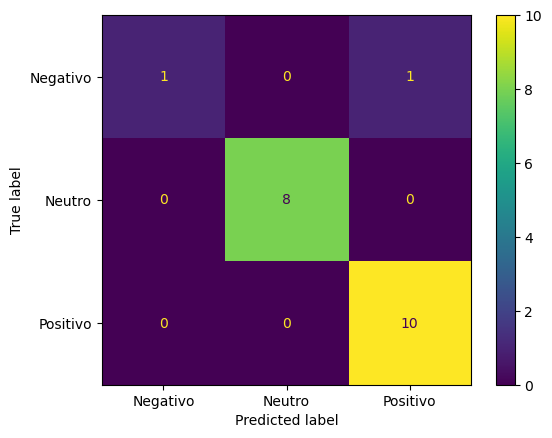

In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,
                              display_labels=knn_model.classes_)
disp.plot()
plt.show()

<div style="color:#ed145b;font-family:inter;font-size:32px">Conclusão</div>
<hr style="background-color:#ed145b;height:4px"></hr>

<div style="color:black;font-family:inter;font-size:16px">O modelo otimizado consegue distinguir positivo e neutro de forma assertiva. Com negativos, o modelo ainda se equivoca, mas conforme aumenta a quantidade de dados, o modelo vai melhorando seu fit com essa rotina de <b>treinamento, validação, comparação e otimização</b>.
</div>

In [25]:
# Salvar modelo para reutilizar depois
pickle.dump(knn_model, open("knn_otimizado.pkl", 'wb'))